In [30]:
import numpy as np
import math
import random
from typing import List, Dict, Any

# ============================
# GLOBAL CONFIG
# ============================

INSTANCE_PATH = r"gecco19-thief\src\main\resources\pla33810-n33809.txt"

# TSP / 2-OPT
CAND_K = 30
TWO_OPT_PASSES = 5000

# EVOLUTION
POP_SIZE = 300
GENERATIONS = 500

# ITEM SEEDING PARAMETERS
CAP_FACTORS = [0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
GAMMAS = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30]
HEUR_MODES = ["suffix", "profit_adj", "time_ratio"]
MUT_RATE = 0.003
LIGHT_MUT_RATE = 0.02

GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# HYPERVOLUME (same reference used in your comparisons)
IDEAL = (66048945.0, -4860715.0)
NADIR = (168432301.0, 0.0)

MAX_ARCHIVE = 20          # same behaviour as second file (cap via crowding)
archive_pop = []          # stores solutions
archive_objs = []         # stores (T,P,W)

# ===============================================================
# PARSE INSTANCE
# ===============================================================
def parse_ttp(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    dim = num_items = None
    capacity = v_min = v_max = None
    edge_type = None

    i = 0
    while i < len(lines):
        L = lines[i]
        if L.startswith("DIMENSION"):
            dim = int(L.split(":")[1])
        elif L.startswith("NUMBER OF ITEMS"):
            num_items = int(L.split(":")[1])
        elif L.startswith("CAPACITY OF KNAPSACK"):
            capacity = float(L.split(":")[1])
        elif L.startswith("MIN SPEED"):
            v_min = float(L.split(":")[1])
        elif L.startswith("MAX SPEED"):
            v_max = float(L.split(":")[1])
        elif L.startswith("EDGE_WEIGHT_TYPE"):
            edge_type = L.split(":")[1].strip()
        elif L.startswith("NODE_COORD_SECTION"):
            break
        i += 1

    i += 1
    coords = np.zeros((dim, 2), float)
    for k in range(dim):
        idx, x, y = lines[i + k].split()
        coords[int(idx) - 1] = [float(x), float(y)]
    i += dim

    while "ITEMS SECTION" not in lines[i]:
        i += 1
    i += 1

    items = []
    for j in range(num_items):
        parts = lines[i + j].split()
        profit = float(parts[1])
        weight = float(parts[2])
        city = int(parts[3]) - 1
        items.append((profit, weight, city))

    return {
        "dim": dim,
        "coords": coords,
        "items": items,
        "capacity": capacity,
        "v_min": v_min,
        "v_max": v_max,
        "edge_type": edge_type,
    }


# ===============================================================
# TSP (Nearest Neighbour + 2-opt with candidate lists)
# ===============================================================
def nn_tour(coords: np.ndarray) -> np.ndarray:
    n = len(coords)
    unvis = np.ones(n, dtype=bool)
    tour = np.empty(n, int)
    cur = 0

    for t in range(n):
        tour[t] = cur
        unvis[cur] = False
        if t == n - 1:
            break
        dx = coords[unvis, 0] - coords[cur, 0]
        dy = coords[unvis, 1] - coords[cur, 1]
        nxt = np.where(unvis)[0][np.argmin(dx * dx + dy * dy)]
        cur = nxt

    return tour


def compute_dists(order: np.ndarray, coords: np.ndarray) -> np.ndarray:
    n = len(order)
    out = np.empty(n, float)
    for i in range(n):
        a = order[i]
        b = order[(i + 1) % n]
        d = math.sqrt(((coords[a] - coords[b]) ** 2).sum())
        out[i] = math.ceil(d)
    return out


def city_dist(a: int, b: int, coords: np.ndarray) -> float:
    dx = coords[a, 0] - coords[b, 0]
    dy = coords[a, 1] - coords[b, 1]
    return math.ceil(math.hypot(dx, dy))


def build_candidate_lists(coords: np.ndarray, k: int = 10):
    """
    Build K nearest-neighbour candidate list per city using sklearn KD-tree.

    Returns list of length n: cand[i] is list of neighbour city indices for city i.
    If sklearn is unavailable, returns None and we skip 2-opt.
    """
    n = len(coords)
    try:
        from sklearn.neighbors import NearestNeighbors
    except ImportError:
        print("[WARN] sklearn not available; skipping candidate-based 2-opt.")
        return None

    print(f"[INFO] Building candidate lists with k={k} using sklearn...")
    nn = NearestNeighbors(n_neighbors=min(k + 1, n), algorithm="kd_tree")
    nn.fit(coords)
    _, inds = nn.kneighbors(coords)

    cand = []
    for i in range(n):
        neigh = [j for j in inds[i] if j != i]
        cand.append(neigh[:k])
    return cand


def two_opt_with_candidates(order: np.ndarray,
                            coords: np.ndarray,
                            cand_lists,
                            max_passes=TWO_OPT_PASSES) -> np.ndarray:

    if cand_lists is None:
        return order

    n = len(order)
    pos = np.empty(n, int)
    for idx, city in enumerate(order):
        pos[city] = idx

    # track best found so far for print purposes ONLY
    best_len = sum(city_dist(order[i], order[(i+1)%n], coords) for i in range(n))

    for p in range(max_passes):
        improved = False

        for i in range(n - 1):
            a = order[i]
            b = order[i + 1]

            for c in cand_lists[a]:
                j = pos[c]
                if j <= i + 1 or j >= n - 1:
                    continue

                d = order[j + 1]

                old_len = city_dist(a, b, coords) + city_dist(c, d, coords)
                new_len = city_dist(a, c, coords) + city_dist(b, d, coords)

                if new_len < old_len:
                    order[i+1:j+1] = order[i+1:j+1][::-1]

                    for t in range(i+1, j+1):
                        pos[order[t]] = t

                    improved = True
                    curr_len = sum(city_dist(order[k], order[(k+1)%n], coords) for k in range(n))
                    best_len = min(best_len, curr_len)
                    break

            if improved:
                break

        if not improved:
            print(f"[2-OPT] Early stop at pass {p+1}, no improvement.")
            break

        # print every 50 iterations
        if (p+1) % 50 == 0:
            print(f"[2-OPT] Pass {p+1}  |  Best length so far = {best_len}")

    return order



# ===============================================================
# PRECOMPUTE ITEM DATA
# ===============================================================
def prep_items(inst, order, dists):
    n = inst["dim"]
    city_pos = np.empty(n, int)
    for pos, city in enumerate(order):
        city_pos[city] = pos

    suffix = np.empty(len(dists))
    run = 0.0
    for i in reversed(range(len(dists))):
        run += dists[i]
        suffix[i] = run

    recs = []
    for idx, (p, w, c) in enumerate(inst["items"]):
        pos = city_pos[c]
        recs.append({
            "index": idx,
            "city": c,
            "pos": pos,
            "profit": p,
            "weight": w,
            "suffix": float(suffix[pos])
        })

    return recs, float(suffix[0])


# ===============================================================
# EVALUATION
# ===============================================================
def evaluate(inst, order, dists, recs, chosen):
    cap = inst["capacity"]
    vmin = inst["v_min"]
    vmax = inst["v_max"]

    city_w = np.zeros(len(order), float)
    city_p = np.zeros(len(order), float)

    for r, ch in zip(recs, chosen):
        if ch:
            city_w[r["pos"]] += r["weight"]
            city_p[r["pos"]] += r["profit"]

    alpha = (vmax - vmin) / cap

    W = 0.0
    T = 0.0
    P = 0.0

    for i in range(len(order)):
        W += city_w[i]
        v = vmax - alpha * W
        if v < vmin:
            v = vmin
        T += dists[i] / v
        P += city_p[i]

    return T, P, W


# ===============================================================
# CAPACITY REPAIR
# ===============================================================
def repair_to_capacity(chosen, recs, capacity):
    """
    Ensure total weight <= capacity by dropping worst profit/weight items.
    """
    weights = np.array([r["weight"] for r in recs], dtype=float)
    profits = np.array([r["profit"] for r in recs], dtype=float)

    chosen = list(chosen)
    total_w = float((weights * np.array(chosen, dtype=float)).sum())

    if total_w <= capacity:
        return chosen

    chosen_idx = [i for i, flag in enumerate(chosen) if flag]
    chosen_idx.sort(key=lambda i: profits[i] / weights[i])  # worst first

    for i in chosen_idx:
        if total_w <= capacity:
            break
        chosen[i] = False
        total_w -= weights[i]

    return chosen


# ===============================================================
# GREEDY SEEDING MODES
# ===============================================================

def build_seed(inst, order, dists, recs, total_dist):
    mode = random.choice(HEUR_MODES)
    gamma = random.choice(GAMMAS)
    power = random.choice([0.5, 1.0, 2.0])
    cap_target = random.choice(CAP_FACTORS) * inst["capacity"]

    if mode == "suffix":
        for r in recs:
            r["score"] = (r["suffix"] / total_dist) ** power

    elif mode == "profit_adj":
        for r in recs:
            adj = r["weight"] * (1.0 + gamma * (r["suffix"] / total_dist))
            r["score"] = r["profit"] / adj

    else:
        alpha = (inst["v_max"] - inst["v_min"]) / inst["capacity"]
        for r in recs:
            dv = alpha * r["weight"]
            v_before = inst["v_max"]
            v_after = max(inst["v_max"] - dv, inst["v_min"])
            dt = r["suffix"] / v_after - r["suffix"] / v_before
            if dt <= 0:
                dt = 1e-6
            r["score"] = r["profit"] / dt

    idxs = sorted(range(len(recs)), key=lambda i: recs[i]["score"], reverse=True)

    chosen = [False] * len(recs)
    W = 0.0
    for i in idxs:
        w = recs[i]["weight"]
        if W + w <= cap_target:
            chosen[i] = True
            W += w

    chosen = repair_to_capacity(chosen, recs, inst["capacity"])
    return chosen


# ===============================================================
# MUTATION / CROSSOVER
# ===============================================================
def mutate(chosen, rate=MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def light_mutate(chosen, rate=LIGHT_MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def crossover(a, b):
    n = len(a)
    cut = random.randint(0, n - 1)
    return a[:cut] + b[cut:]


# ===============================================================
# NSGA-II
# ===============================================================
def dominates(A, B):
    t1, p1, _ = A
    t2, p2, _ = B
    return (t1 <= t2 and p1 >= p2) and (t1 < t2 or p1 > p2)


def pareto_rank(objs):
    n = len(objs)
    dom_counts = [0] * n
    dominated_by = [[] for _ in range(n)]
    fronts = [[]]

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if dominates(objs[i], objs[j]):
                dominated_by[i].append(j)
            elif dominates(objs[j], objs[i]):
                dom_counts[i] += 1
        if dom_counts[i] == 0:
            fronts[0].append(i)

    k = 0
    while fronts[k]:
        nxt = []
        for i in fronts[k]:
            for j in dominated_by[i]:
                dom_counts[j] -= 1
                if dom_counts[j] == 0:
                    nxt.append(j)
        k += 1
        fronts.append(nxt)

    return fronts[:-1]

def crowding_distance(front_indices, objs):
    """
    front_indices: list of indices (into objs) belonging to one Pareto front
    objs: list of (time, profit, weight)

    Returns: dict {idx: distance}
    """
    if not front_indices:
        return {}

    # init distances
    dist = {i: 0.0 for i in front_indices}

    # use only time (index 0, minimise) and profit (index 1, maximise)
    num_obj = 2
    for m in range(num_obj):
        vals = [(i, objs[i][m]) for i in front_indices]

        if m == 0:
            # time: smaller is better → sort ascending
            vals.sort(key=lambda x: x[1])
        else:
            # profit: larger is better → sort descending
            vals.sort(key=lambda x: x[1], reverse=True)

        v_min = vals[0][1]
        v_max = vals[-1][1]
        if v_max == v_min:
            # no spread on this dimension
            continue

        # boundary points get infinite crowding
        dist[vals[0][0]]  = float("inf")
        dist[vals[-1][0]] = float("inf")

        # internal points
        for k in range(1, len(vals) - 1):
            i_prev, v_prev = vals[k - 1]
            i_curr, v_curr = vals[k]
            i_next, v_next = vals[k + 1]
            incr = (v_next - v_prev) / (v_max - v_min)
            dist[i_curr] += incr

    return dist

# ===============================================================
# EVOLUTION LOOP
# ===============================================================
def run_evo(inst, order, dists, recs, total_dist,
            gens=GENERATIONS, pop_size=POP_SIZE):

    pop = [build_seed(inst, order, dists, recs, total_dist)
           for _ in range(pop_size)]
    objs = [evaluate(inst, order, dists, recs, c) for c in pop]

    for g in range(gens):
        print(f"[GEN {g:4d}] min_time={min(o[0] for o in objs):.1f}  max_profit={max(o[1] for o in objs):.0f}")

        offspring = []
        while len(offspring) < pop_size:
            a, b = random.sample(pop, 2)
            child = crossover(a, b)
            child = mutate(child)

            child = repair_to_capacity(child, recs, inst["capacity"]) 
            _, _, W = evaluate(inst, order, dists, recs, child)
            cap = inst["capacity"]
            min_fill = 0.30 + 0.40 * (g / gens)   # starts at 30% → rises to 70% by last gen
            target_weight = cap * min_fill

            if W < target_weight:
                child = light_mutate(child)
                child = repair_to_capacity(child, recs, inst["capacity"])

            offspring.append(child)

        off_objs = [evaluate(inst, order, dists, recs, c) for c in offspring]

        combined = pop + offspring
        comb_objs = objs + off_objs

        fronts = pareto_rank(comb_objs)

        new_pop = []
        new_objs = []

        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                for idx in front:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
            else:
                need = pop_size - len(new_pop)
                picks = random.sample(front, need)
                for idx in picks:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
                break

        pop, objs = new_pop, new_objs

        # =====================================================
        # 🔥 update persistent ND archive (not used in evolution)
        # =====================================================
        global archive_pop, archive_objs
        
        # merge old archive with current population objs
        combo_objs = archive_objs + objs

        # find global ND set across all time
        fronts = pareto_rank(combo_objs)
        nd = fronts[0]  # non-dominated indices

        newA_pop  = []
        newA_objs = []
        for i in nd:
            if i < len(archive_objs):      # from previous archive
                newA_pop.append(archive_pop[i])
                newA_objs.append(archive_objs[i])
            else:                           # new individuals belong to current pop
                j = i - len(archive_objs)
                newA_pop.append(pop[j])
                newA_objs.append(objs[j])

        # remove duplicates using rounded (T,P) key preferring lower weight
        uniq = {}
        for s,o in zip(newA_pop,newA_objs):
            key = (round(o[0],3), round(o[1],1))
            if key not in uniq or o[2] < uniq[key][1][2]:
                uniq[key]=(s,o)

        archive_pop  = [v[0] for v in uniq.values()]
        archive_objs = [v[1] for v in uniq.values()]

        # enforce MAX_ARCHIVE via crowding measure (spread retention)
        if len(archive_objs) > MAX_ARCHIVE:
            idxs = list(range(len(archive_objs)))
            cd = crowding_distance(idxs, archive_objs)
            keep = sorted(idxs, key=lambda k: cd.get(k,0.0), reverse=True)[:MAX_ARCHIVE]
            archive_pop  = [archive_pop[k] for k in keep]
            archive_objs = [archive_objs[k] for k in keep]

    return pop, objs

# ===============================================================
# HYPERVOLUME
# ===============================================================

def compute_hypervolume(objs, ideal, nadir):
    """
    objs = list of (time, profit, weight)
    ideal, nadir = (t_min, -p_max), (t_max, 0) in minimisation space
    """
    # convert to minimisation form
    pts = [(t, -p) for (t, p, w) in objs]

    # filter + sort by time asc (objective1), profit-desc becomes obj2 asc
    pts = sorted(pts, key=lambda x: x[0])

    hv = 0.0
    prev_t = ideal[0]
    for (t, p) in pts:
        width = t - prev_t
        height = nadir[1] - p
        if width > 0 and height > 0:
            hv += width * height
        prev_t = t

    # last slice to reference
    width = nadir[0] - prev_t
    height = nadir[1] - pts[-1][1]
    if width > 0 and height > 0:
        hv += width * height

    return hv



# ===============================================================
# RUN EVERYTHING
# ===============================================================
print("[INFO] Loading TTP instance…")
inst = parse_ttp(INSTANCE_PATH)

print("[INFO] Building NN tour…")
order = nn_tour(inst["coords"])
dists = compute_dists(order, inst["coords"])
print(f"[TSP] NN length = {dists.sum():.0f}")

cand_lists = build_candidate_lists(inst["coords"], k=CAND_K)
if cand_lists is not None:
    print("[INFO] Running 2-opt with candidate lists…")
    order = two_opt_with_candidates(order, inst["coords"], cand_lists, max_passes=TWO_OPT_PASSES)
    dists = compute_dists(order, inst["coords"])
    print(f"[TSP] Improved length = {dists.sum():.0f}")
else:
    print("[INFO] Skipping 2-opt improvement.")

print("[INFO] Preprocessing items…")
recs, total_dist = prep_items(inst, order, dists)

pop, objs = run_evo(inst, order, dists, recs, total_dist,
                    gens=GENERATIONS, pop_size=POP_SIZE)

print("\n=== FINAL PARETO FRONT ===")
paired = sorted(zip(pop, objs), key=lambda x: x[1][0])
for _, (T, P, W) in paired:
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}") 

# ===================== HYPERVOLUME OUTPUT =====================
# Ideal & nadir from your earlier results
hv_raw = compute_hypervolume(objs, IDEAL, NADIR)

# normalised HV in [0,1]^2
range_t = NADIR[0] - IDEAL[0]
range_p = -IDEAL[1]
hv_norm = hv_raw / (range_t * range_p)

print("\n=== HYPERVOLUME ===")
print(f"Raw HV   : {hv_raw:.6e}")
print(f"Norm HV  : {hv_norm:.6f}")

print("\n=== ARCHIVE SUMMARY =======================")
print(f"ND archive size: {len(archive_objs)}")
for (T,P,W) in sorted(archive_objs, key=lambda x:x[0]):
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}")

# HV on archive 
hv_raw_nd = compute_hypervolume(archive_objs, IDEAL, NADIR)
hv_norm_nd = hv_raw_nd / (range_t * range_p)

print("\n=== GLOBAL HYPERVOLUME (ARCHIVE) ===")
print(f"Raw HV   : {hv_raw_nd:.6e}")
print(f"Norm HV  : {hv_norm_nd:.6f}")




[INFO] Loading TTP instance…
[INFO] Building NN tour…
[TSP] NN length = 77332499
[INFO] Building candidate lists with k=30 using sklearn...
[INFO] Running 2-opt with candidate lists…
[2-OPT] Pass 50  |  Best length so far = 77205235
[2-OPT] Pass 100  |  Best length so far = 77134009
[2-OPT] Pass 150  |  Best length so far = 77009623
[2-OPT] Pass 200  |  Best length so far = 76924953
[2-OPT] Pass 250  |  Best length so far = 76863893
[2-OPT] Pass 300  |  Best length so far = 76791878
[2-OPT] Pass 350  |  Best length so far = 76740143
[2-OPT] Pass 400  |  Best length so far = 76668193
[2-OPT] Pass 450  |  Best length so far = 76560719
[2-OPT] Pass 500  |  Best length so far = 76492597
[2-OPT] Pass 550  |  Best length so far = 76423280
[2-OPT] Pass 600  |  Best length so far = 76350935
[2-OPT] Pass 650  |  Best length so far = 76293022
[2-OPT] Pass 700  |  Best length so far = 76231938
[2-OPT] Pass 750  |  Best length so far = 76159729
[2-OPT] Pass 800  |  Best length so far = 76098772
[2

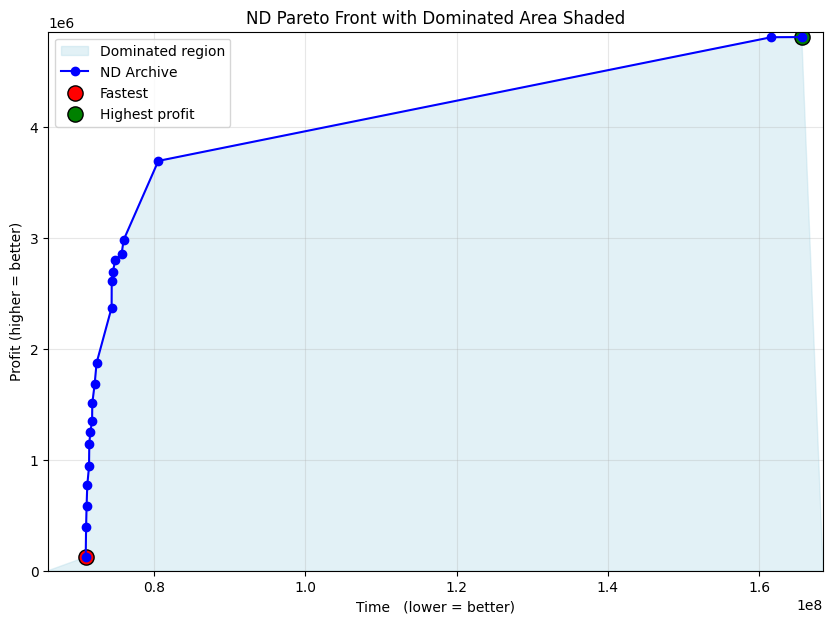

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Extract ND archive
pts = np.array([(t,p) for (t,p,w) in archive_objs])
pts = pts[pts[:,0].argsort()]   # sort by time

times   = pts[:,0]
profits = pts[:,1]

# Define axis bounds
T_min, T_max = IDEAL[0], NADIR[0]             # full domain
P_min, P_max = 0, 4_860_715.0                 # force to global max profit

# Build polygon for dominated region shading ================================
# The dominated area is everything right & below the Pareto curve.
# We close the polygon down to the lower boundary to shade fully.

poly_x = np.concatenate([[T_min], times, [T_max, T_min]])
poly_y = np.concatenate([[P_min], profits, [P_min, P_min]])

plt.figure(figsize=(10,7))

# SHADING — This is what you asked for
plt.fill(poly_x, poly_y, color="lightblue", alpha=0.35, label="Dominated region")

# Plot Pareto points
plt.plot(times, profits, "-o", color="blue", label="ND Archive", markersize=6)

# Mark extremes
best_t_idx = np.argmin(times)
best_p_idx = np.argmax(profits)
plt.scatter(times[best_t_idx], profits[best_t_idx], s=120, color="red", edgecolor="black", label="Fastest")
plt.scatter(times[best_p_idx], profits[best_p_idx], s=120, color="green", edgecolor="black", label="Highest profit")

# Labels
plt.xlabel("Time   (lower = better)")
plt.ylabel("Profit (higher = better)")
plt.title("ND Pareto Front with Dominated Area Shaded")

# Force axis range to full domain (requested)
plt.xlim(T_min, T_max)
plt.ylim(P_min, P_max)

plt.grid(alpha=0.3)
plt.legend()
plt.show()
